# Exploring FIFA 20 Players and Attributes

## Background
FIFA 2020 is one of the world's most popular video games. It is a football simulation video game published by Electronic Arts (EA Sports) as part of the FIFA series. It is the 27th installment in the FIFA series and was released on 27 September 2019 for Microsoft Windows, PlayStation 4, Xbox One, and Nintendo Switch.

Historically the FIFA series has been one of the main revenue generators for Electronic Arts (EA). According to sportbible, across all sports franchise titles, including FIFA and Madden, EA generated a total of 1.49 billion through the Ultimate Team platform --- which is a $120 million increase on last year's revenue total of 1.37 billion. The Ultimate team platform is a gameplay experience that allows gamers to build their team and compete against others. The goal is to create your dream squad with superstars from past and present. For fiscal 2020, EA's revenue topped 5.5 billion, with 2.7 billion of that generated from players spending money on in-game content or live services. Gamers looking to take advantage of in-game purchases by finding hidden gems, players with high potential, or already established superstars to build their team. 

## Goal
This document explores in-game players from the FIFA 20 database to understand how different characteristics, traits, demographics, and more influence players' overall rating and potential. Throughout this analysis, we will uncover insights to drive a machine learning model. 

The objective of the ML model will be to predict the potential of a player in the game. Uncovering a player's potential is vital for the gameplay experience because it gives gamers insights on which players have the most upsell or player development opportunities. This strategy will give EA sports the resources to price individual players higher/lower based on their potential score, thus converting in-app purchases.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import random as rand
import sklearn


sns.set_style("darkgrid", {"axes.facecolor": ".9"})


# Setting print options
pd.set_option('display.max_rows',     500)
pd.set_option('display.max_columns',  500)
pd.set_option('display.width',       1000)
pd.set_option('display.max_colwidth', 100)

In [2]:
fifa_20 = pd.read_csv('players/players_20.csv')

## Functions

In [3]:
# Function to plot bar charts
def barplot_count(column, count, figsize = (15,7),
                  title = None, ylabel = None, 
                  xlabel = None, axis_fontsize = 20, 
                  title_fontsize = 24, barcolor = None,
                  edgecolor = 'black', datalabelcolor = 'black',
                  datalabelheight = 5, datalabelsize = 16,
                  ylim = None, titlepadding = 1.02
                  ):
    
    fig, ax = plt.subplots(figsize=figsize, dpi = 300) 
    
    # Bar formatting
    ax.bar(column, count, color = barcolor, edgecolor = edgecolor)
    
    # data labels: zip joins x and y coordinates in pairs
    for x,y in zip(column,count):

        label = "{}".format(str(y))

        ax.annotate(label, # this is the text
                     (x,y - datalabelheight), # this is the point to label
                     textcoords = "offset points", # how to position the text
                     xytext = (0,10), # distance from text to points (x,y)
                     ha = 'center',
                     fontsize = datalabelsize,
                     color = datalabelcolor)
        
    ax.set_title(title, fontsize = title_fontsize, y = titlepadding)
    ax.set_ylabel(ylabel,  fontsize=axis_fontsize) 
    ax.set_xlabel(xlabel,  fontsize=axis_fontsize) 
    ax.tick_params(axis='both', which='major', labelsize=axis_fontsize)
    ax.set_ylim(0, max(count) + ylim)
    plt.tight_layout()
    plt.show()

In [4]:
# heatmap function
def heatMap(df, mirror):

   # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
    if mirror == True:
        #Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
        #Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns)
        #Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns, rotation = 360)
        #show plot

    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(corr)
        dropSelf[np.triu_indices_from(dropSelf)] = True
        # Generate Color Map
        colormap = sns.diverging_palette(220, 10, as_cmap=True)
        # Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
        # Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns)
        # Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns, rotation = 360)
        # show plot
        plt.show()

---------------------------------

# Cleaning

In [5]:
# dropping uncessary columns
fifa_20.drop(['player_url','long_name'], axis = 1, inplace = True)

In [6]:
# Convert dob to date format
fifa_20[["dob", "joined"]] = fifa_20[["dob", "joined"]].apply(pd.to_datetime)

# Convert contract end year to date trunc
fifa_20['contract_valid_until'] = pd.to_datetime(fifa_20['contract_valid_until'], format='%Y')

In [7]:
# Convert category variables
categories = ['preferred_foot', 'work_rate', 
              'body_type', 'real_face']

for col in fifa_20.columns:
    if col in categories:
        fifa_20[col] = fifa_20[col].astype('category')

In [8]:
# # converting to integers
# shirts = ['team_jersey_number', 'nation_jersey_number']

# for col in fifa_20.columns:
#     if col in shirts:
#         fifa_20[col] = fifa_20[col].fillna(np.nan).astype('int64')

In [9]:
# converting RES to SUB since they mean the same
fifa_20['team_position'].replace('RES', 'SUB', inplace = True)
fifa_20['team_position'].replace('CF', 'ST', inplace = True)

# adding a new column 'Main Position'
# columns to clean
cleaning_positions = fifa_20.loc[:,['sofifa_id','player_positions', 'team_position']]

# formatting the lpayer position to get single position
cleaning_positions['cleaned'] = cleaning_positions['player_positions']\
                                .apply(lambda row: pd.Series(str(row).split(",")[0]))


## Checking the new cleaned column works
# cleaning_positions.head()

# Convert RES or SUB rows to the new cleaned position
for index, row in cleaning_positions.iterrows():
    if row['team_position'] in ['RES', 'SUB']:
        cleaning_positions.loc[index, "team_position"] = row['cleaned']
        
        
# saving the cleaned variables into original dataframe
fifa_20['main_position'] = cleaning_positions['team_position']


# Checking the new cleaned column works
fifa_20[['player_positions', 'team_position', 'main_position']].head()

,player_positions,team_position,main_position
0,"RW, CF, ST",RW,RW
1,"ST, LW",LW,LW
2,"LW, CAM",CAM,CAM
3,GK,GK,GK
4,"LW, CF",LW,LW


### Adding New Columns

In [10]:
# adding counts for the number of values per column
fifa_20['position_count'] = fifa_20['player_positions'].str.split(',').str.len()
fifa_20['trait_count'] = fifa_20['player_traits'].str.split(',').str.len().fillna(0).astype('int64')
fifa_20['tag_count'] = fifa_20['player_tags'].str.split(',').str.len().fillna(0).astype('int64') 

In [11]:
# adding rank based on rating
fifa_20['ranking'] = fifa_20['overall'].rank(method = 'max', ascending = False).astype('int64')

# valuation ranking
fifa_20['value_rank'] = fifa_20['value_eur'].rank(method = 'max', ascending = False).astype('int64')

# potential change
fifa_20['potential_growth'] = fifa_20['potential'] - fifa_20['overall']

In [12]:
# output dataframe for model
fifa_20.to_csv('fifa_model.csv')

------------------

# Exploration

In [13]:
# # stats on numeric
fifa_20.describe().round(1)

,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,team_jersey_number,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,position_count,trait_count,tag_count,ranking,value_rank,potential_growth
count,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,16980.0,18038.0,1126.0,16242.0,16242.0,16242.0,16242.0,16242.0,16242.0,2036.0,2036.0,2036.0,2036.0,2036.0,2036.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0,18278.0
mean,219738.9,25.3,181.4,75.3,66.2,71.5,2484037.6,9456.9,1.1,2.9,2.4,4740717.4,20.1,12.1,67.7,52.3,57.2,62.5,51.6,64.9,65.4,63.1,61.8,66.4,37.8,63.4,49.7,45.6,52.2,58.7,42.8,55.6,47.3,42.7,52.8,58.5,64.3,64.4,63.5,61.8,63.9,58.2,64.9,62.9,65.2,46.8,55.7,46.4,50.1,53.6,48.4,58.5,46.8,47.6,45.6,16.6,16.4,16.2,16.4,16.7,1.6,0.7,0.1,9517.3,9240.6,5.3
std,27960.2,4.7,6.8,7.0,6.9,6.1,5585481.1,21351.7,0.4,0.7,0.8,11030016.3,16.6,6.7,11.3,14.0,10.4,10.3,16.4,9.8,7.7,7.2,7.5,8.2,10.6,8.4,18.3,19.6,17.4,14.7,17.7,18.9,18.4,17.4,15.2,16.7,15.0,14.8,14.8,9.1,14.2,13.3,11.9,16.0,12.5,19.3,17.3,20.8,19.6,14.0,15.7,11.9,20.1,21.6,21.2,17.7,17.0,16.6,17.1,18.0,0.7,1.1,0.4,5274.7,5293.8,5.6
min,768.0,16.0,156.0,50.0,48.0,49.0,0.0,0.0,1.0,1.0,1.0,13000.0,1.0,1.0,24.0,15.0,24.0,23.0,15.0,27.0,44.0,42.0,35.0,45.0,12.0,41.0,5.0,2.0,5.0,7.0,3.0,4.0,6.0,4.0,8.0,5.0,12.0,11.0,11.0,21.0,12.0,14.0,19.0,12.0,20.0,4.0,9.0,3.0,2.0,9.0,7.0,12.0,1.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
25%,204445.5,22.0,177.0,70.0,62.0,67.0,325000.0,1000.0,1.0,3.0,2.0,563000.0,9.0,6.0,61.0,42.0,50.0,57.0,36.0,59.0,60.0,58.0,57.0,60.8,29.0,58.0,38.0,30.0,44.0,54.0,30.0,50.0,34.0,31.0,43.0,54.0,56.0,57.0,55.0,56.0,56.0,48.0,58.0,56.0,58.0,32.0,44.0,25.0,39.0,44.0,39.0,51.0,29.0,27.0,24.0,8.0,8.0,8.0,8.0,8.0,1.0,0.0,0.0,4756.0,4592.0,0.0
50%,226165.0,25.0,181.0,75.0,66.0,71.0,700000.0,3000.0,1.0,3.0,2.0,1200000.0,17.0,12.0,69.0,54.0,58.0,64.0,56.0,66.0,65.0,63.0,61.0,66.0,39.0,64.0,54.0,49.0,56.0,62.0,44.0,61.0,49.0,41.0,56.0,63.0,67.0,67.0,66.0,62.0,66.0,59.0,66.0,66.0,66.0,51.0,58.0,52.0,55.0,55.0,49.0,60.0,52.0,55.0,52.0,11.0,11.0,11.0,11.0,11.0,1.0,0.0,0.0,9896.0,9318.0,4.0
75%,240795.8,29.0,186.0,80.0,71.0,75.0,2100000.0,8000.0,1.0,3.0,3.0,3700000.0,27.0,18.0,75.0,63.0,64.0,69.0,65.0,72.0,70.0,68.0,66.0,72.0,46.0,69.0,64.0,62.0,64.0,68.0,56.0,68.0,62.0,56.0,64.0,69.0,75.0,75.0,74.0,68.0,74.0,68.0,73.0,74.0,74.0,62.0,69.0,64.0,64.0,64.0,60.0,67.0,64.0,66.0,64.0,14.0,14.0,14.0,14.0,14.0,2.0,1.0,0.0,13977.0,13874.0,9.0
max,252905.0,42.0,205.0,110.0,94.0,95.0,105500000.0,565000.0,5.0,5.0,5.0,195800000.0,99.0,30.0,96.0,93.0,92.0,96.0,90.0,90.0,90.0,92.0,93.0,92.0,65.0,91.0,93.0,95.0,93.0,92.0,90.0,97.0,94.0,94.0,92.0,96.0,97.0,96.0,96.0,96.0,97.0,95.0,95.0,97.0,97.0,94.0,95.0,92.0,95.0,94.0,92.0,96.0,94.0,92.0,90.0,90.0,92.0,93.0,91.0,92.0,3.0,8.0,9.0,18278.0,18278.0,25.0


In [14]:
# # stats on category variables
fifa_20.describe(include=['O'])

,short_name,nationality,club,player_positions,player_tags,team_position,loaned_from,nation_position,player_traits,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,main_position
count,18278,18278,18278,18278,1499,18038,1048,1126,7566,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,16242,18038
unique,17354,162,698,643,83,27,316,26,921,94,94,94,107,103,103,103,107,103,103,103,100,88,88,88,100,98,98,98,98,98,96,110,110,110,96,27
top,J. Rodríguez,England,Norwich City,CB,#Strength,SUB,Sassuolo,SUB,Early Crosser,61+2,61+2,61+2,63+2,63+2,63+2,63+2,63+2,61+2,61+2,61+2,61+2,58+2,58+2,58+2,61+2,59+2,59+2,59+2,59+2,59+2,61+2,63+2,63+2,63+2,61+2,ST
freq,11,1667,33,2322,514,10778,17,587,501,725,725,725,736,727,727,727,736,748,748,748,809,775,775,775,809,682,636,636,636,682,667,621,621,621,667,2105


### Ratings

In [15]:
print('Most Common: {}'.format(fifa_20['overall'].value_counts().nlargest(1).index[0]))
print('Median: {}'.format(int(fifa_20['overall'].median())))
print('Average: {}'.format(int(fifa_20['overall'].mean())))

over_80 = ((fifa_20[fifa_20['overall'] >= 80]['sofifa_id'].count()/fifa_20['sofifa_id'].count())*100).round(2)

Most Common: 66
Median: 66
Average: 66


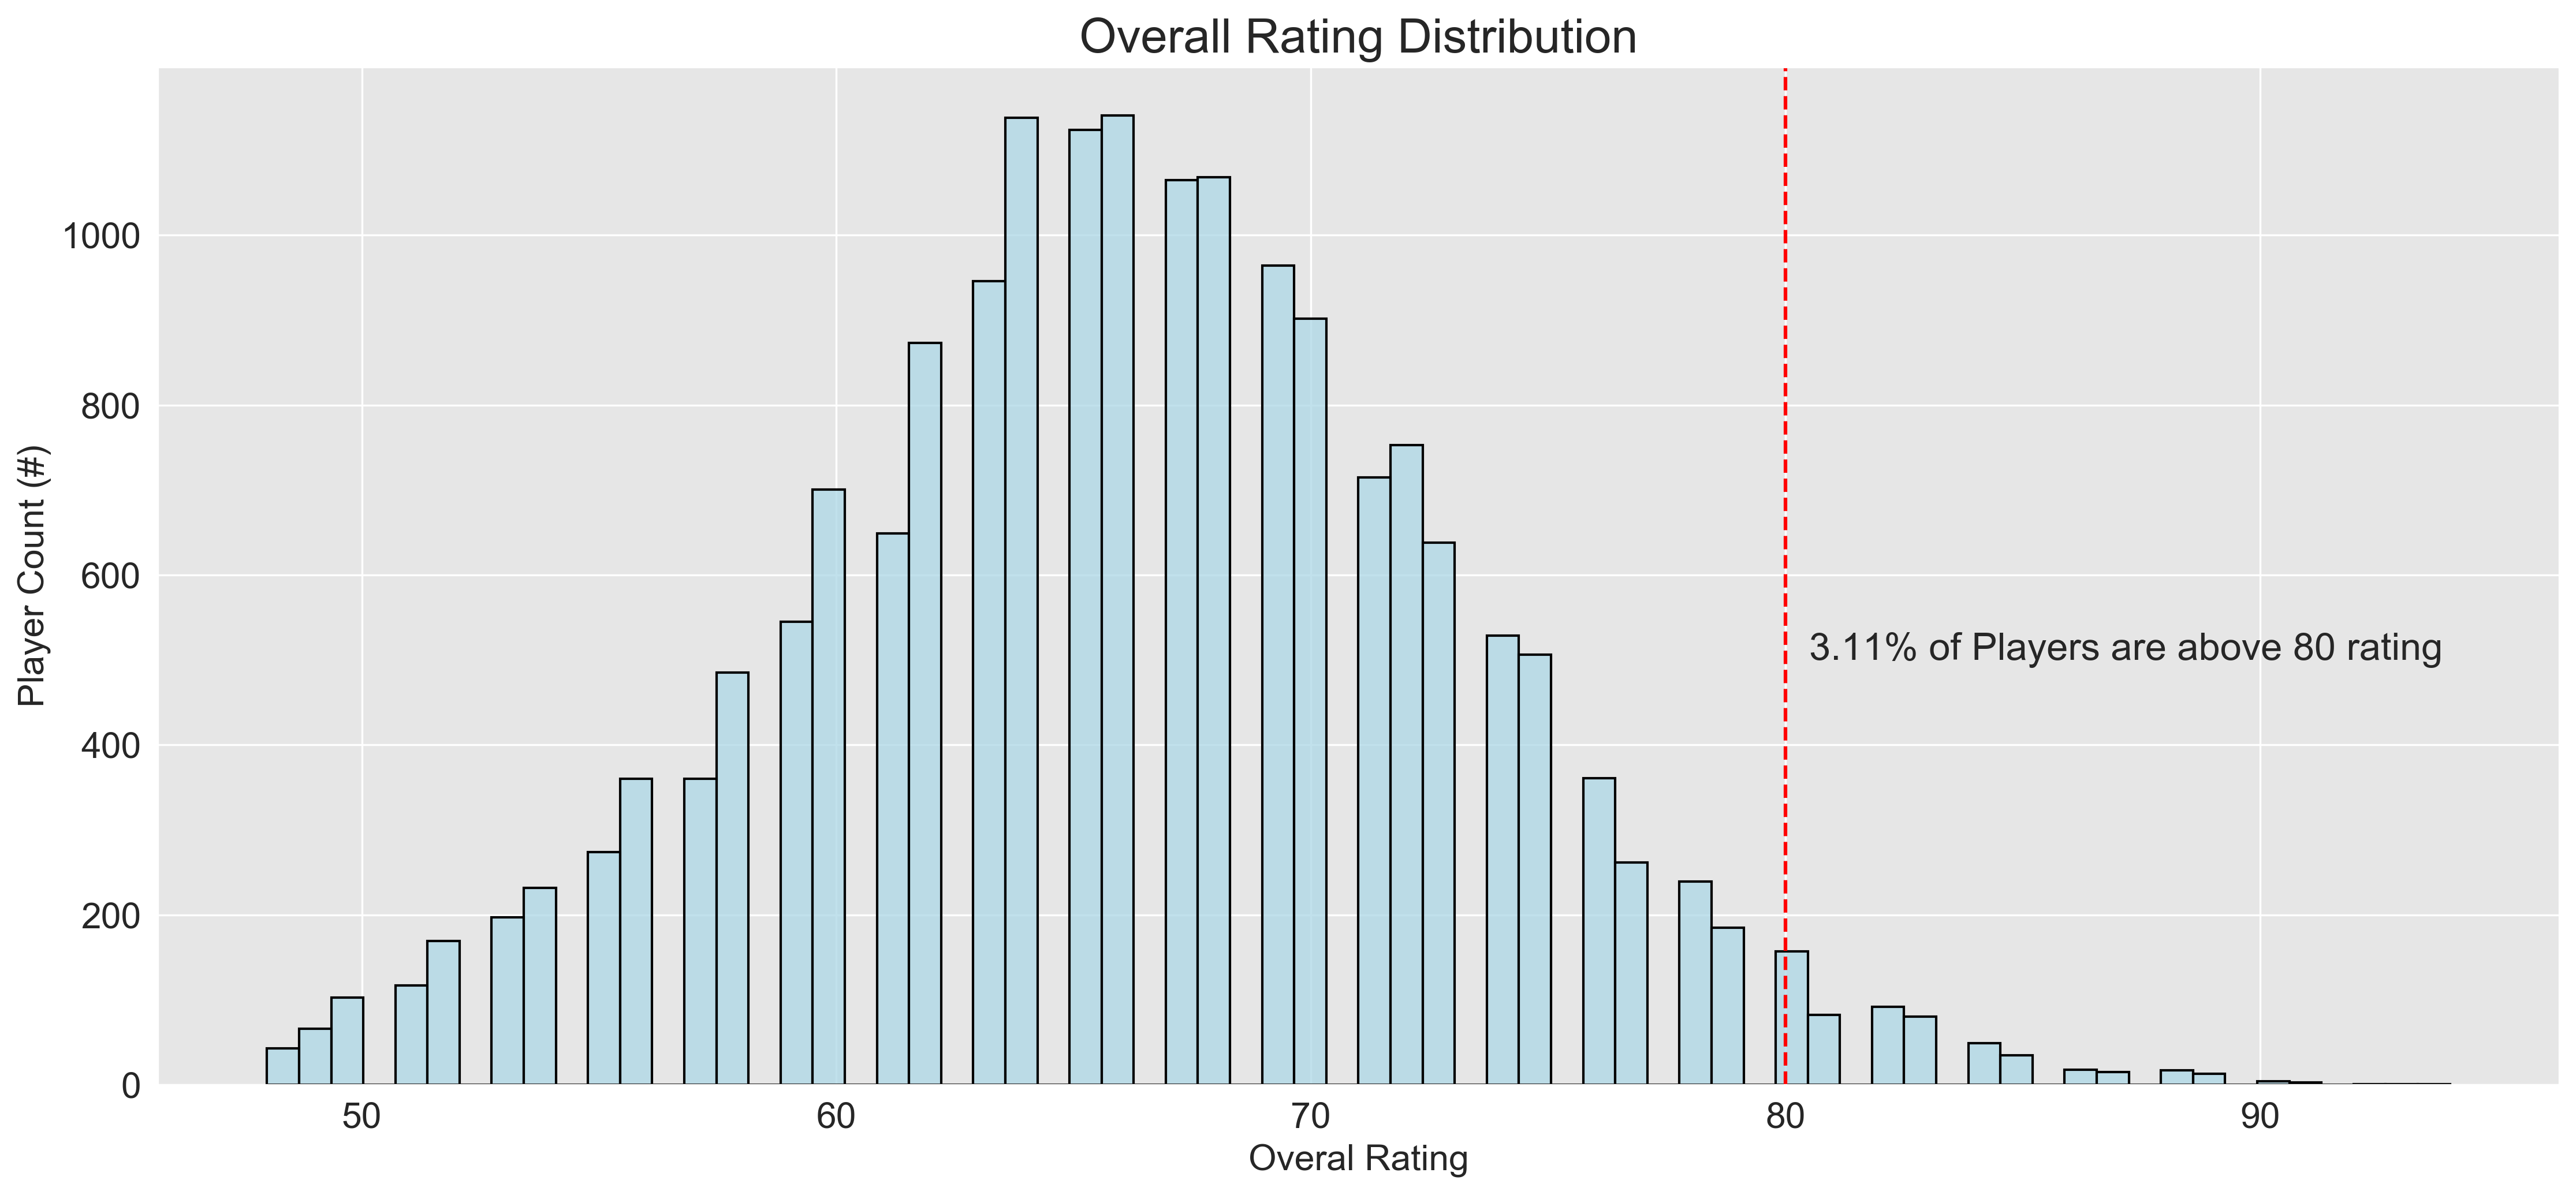

In [16]:
plt.figure(figsize = (15,7), dpi = 300)
plt.title('Overall Rating Distribution', fontsize = 20)
plt.ylabel('Player Count (#)', fontsize = 15)
plt.xlabel('Overal Rating', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.axvline(80, color = 'r', linestyle = '--')
plt.text(80.5, 500, '{}% of Players are above 80 rating'.format(over_80), horizontalalignment='left', fontsize = 16)
sns.histplot(fifa_20['overall'], color = 'lightblue', edgecolor = 'black')
plt.tight_layout()

### Rankings

In [17]:
ranking_compare = fifa_20[fifa_20['ranking'] < fifa_20['value_rank']][['ranking', 'value_rank']]

ranking_compare_dist = (ranking_compare['ranking'] - ranking_compare['value_rank'])

ranking_compare_dist.value_counts().sort_index(ascending = False).head(100).sum()

1386

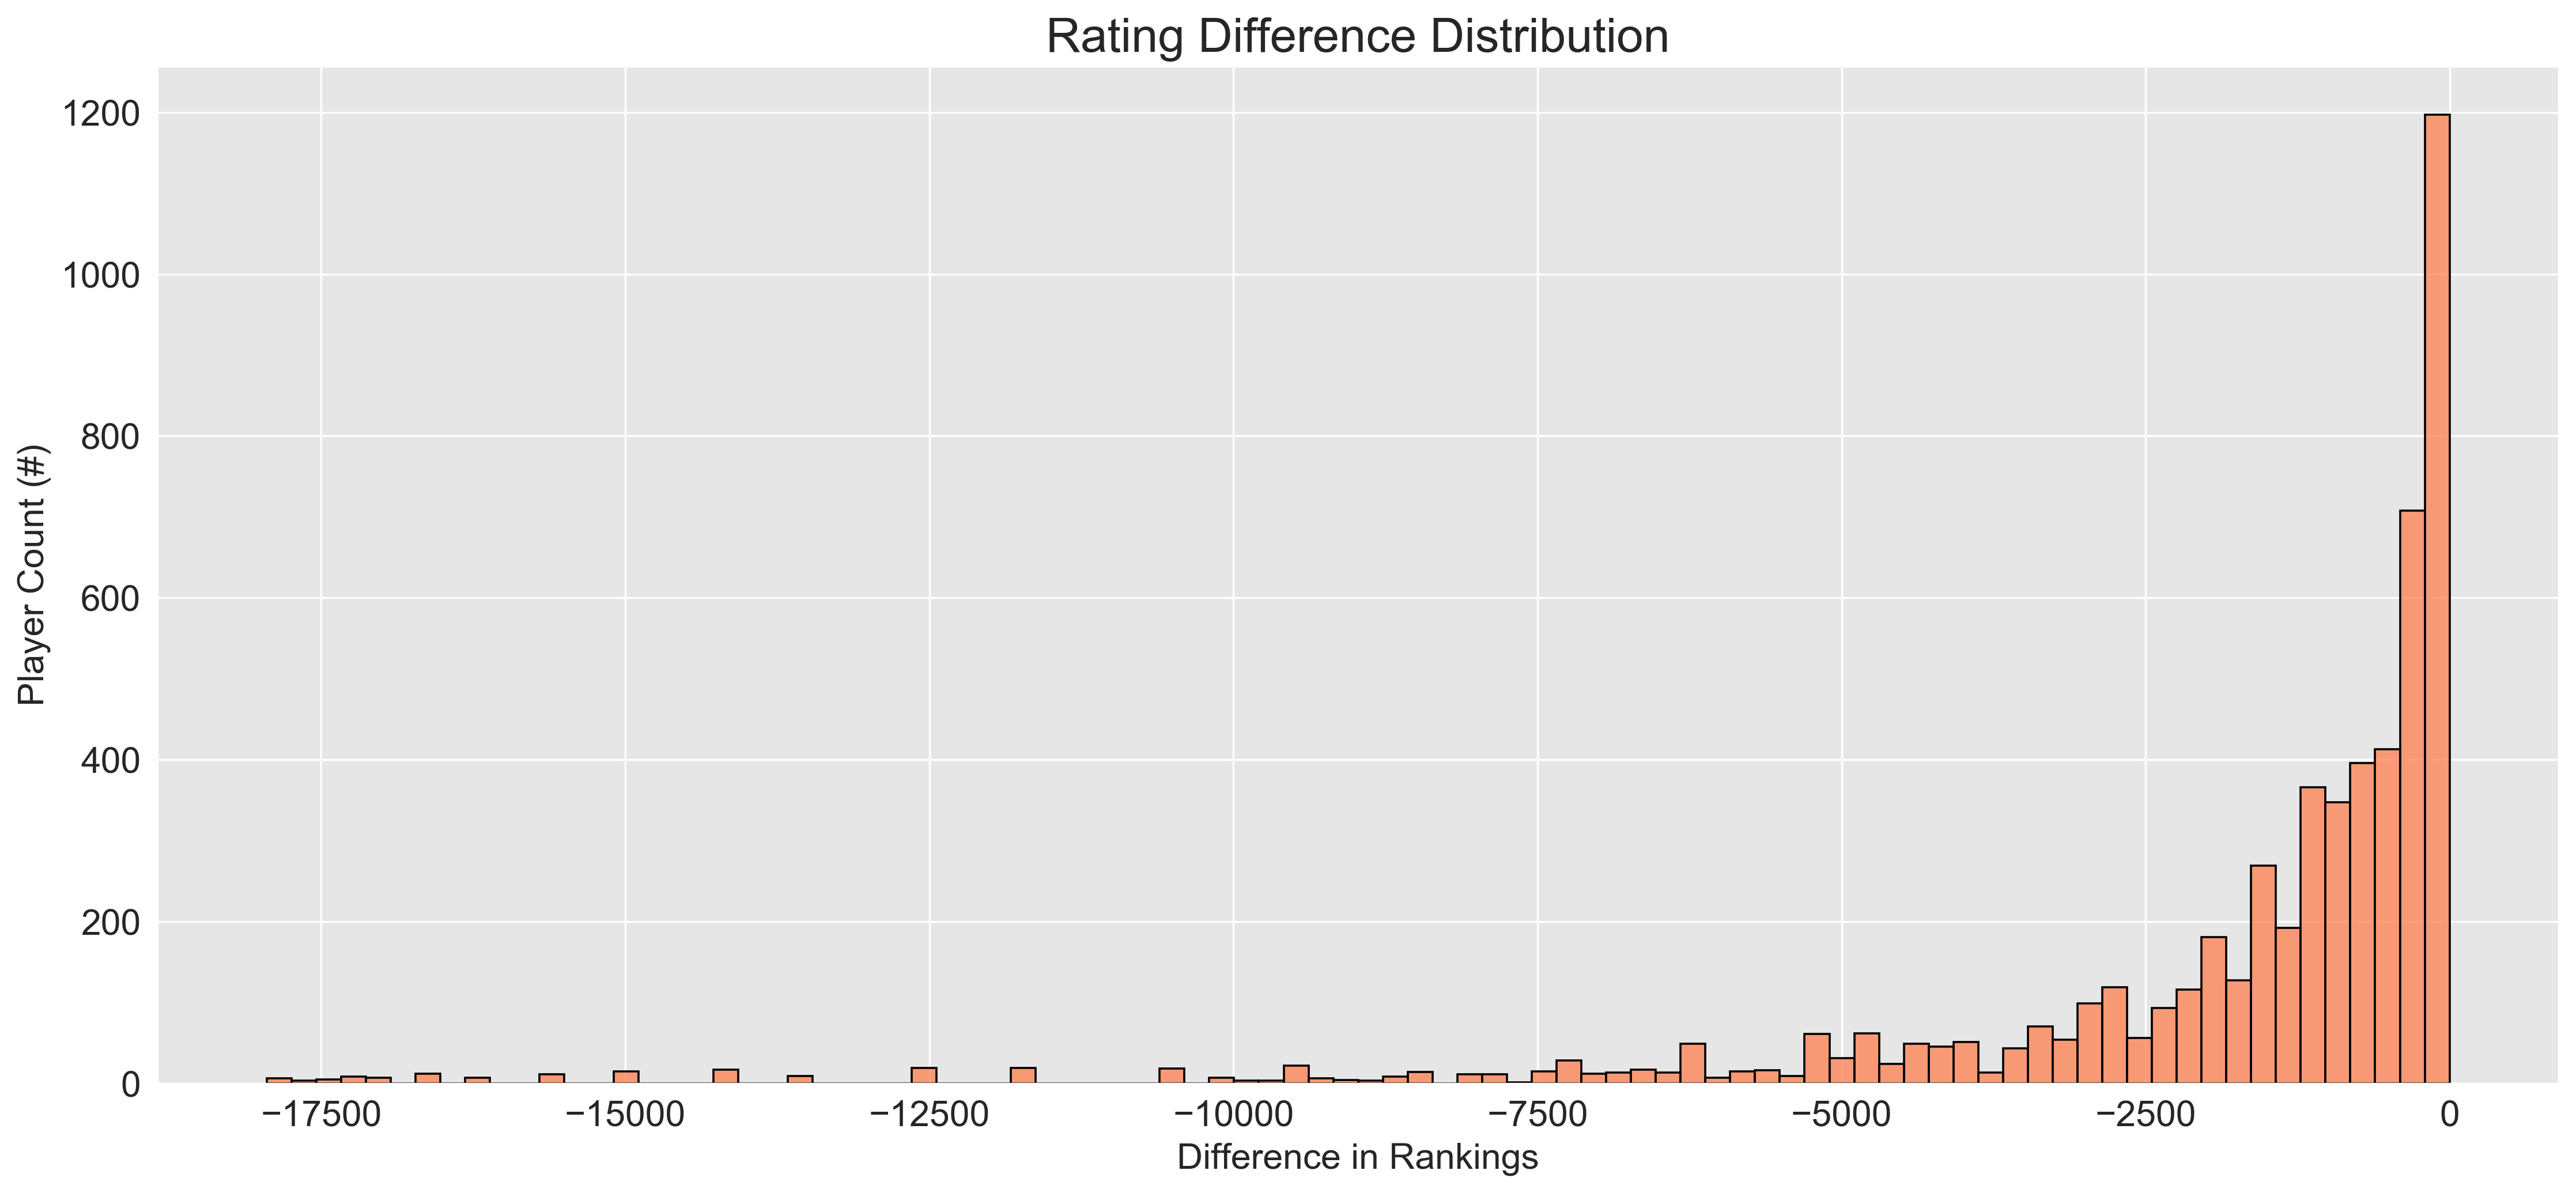

In [18]:
plt.figure(figsize = (15,7), dpi = 300)
plt.title('Rating Difference Distribution', fontsize = 20)
plt.ylabel('Player Count (#)', fontsize = 15)
plt.xlabel('Difference in Rankings', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
sns.histplot(ranking_compare_dist, color = 'coral', edgecolor = 'black')
plt.tight_layout()

### Age

In [19]:
# creating age buckets
fifa_20['age_group'] = ''

for index, row in fifa_20.iterrows():
    
    if row['age'] <= 20:
        fifa_20.loc[index, "age_group"] = 'under 20'
        
    elif row['age'] <= 25:
        fifa_20.loc[index, "age_group"] = 'under 25'
        
    elif row['age'] <= 30:
        fifa_20.loc[index, "age_group"] = 'under 30'
    
    else:
        fifa_20.loc[index, "age_group"] = 'over 30'

In [45]:
# formating for subplots
temp = fifa_20.groupby(by = ['body_type', 'age_group'])['sofifa_id'].count().reset_index()
temp = temp.pivot_table(index = 'body_type', columns = 'age_group', values = 'sofifa_id').reset_index()

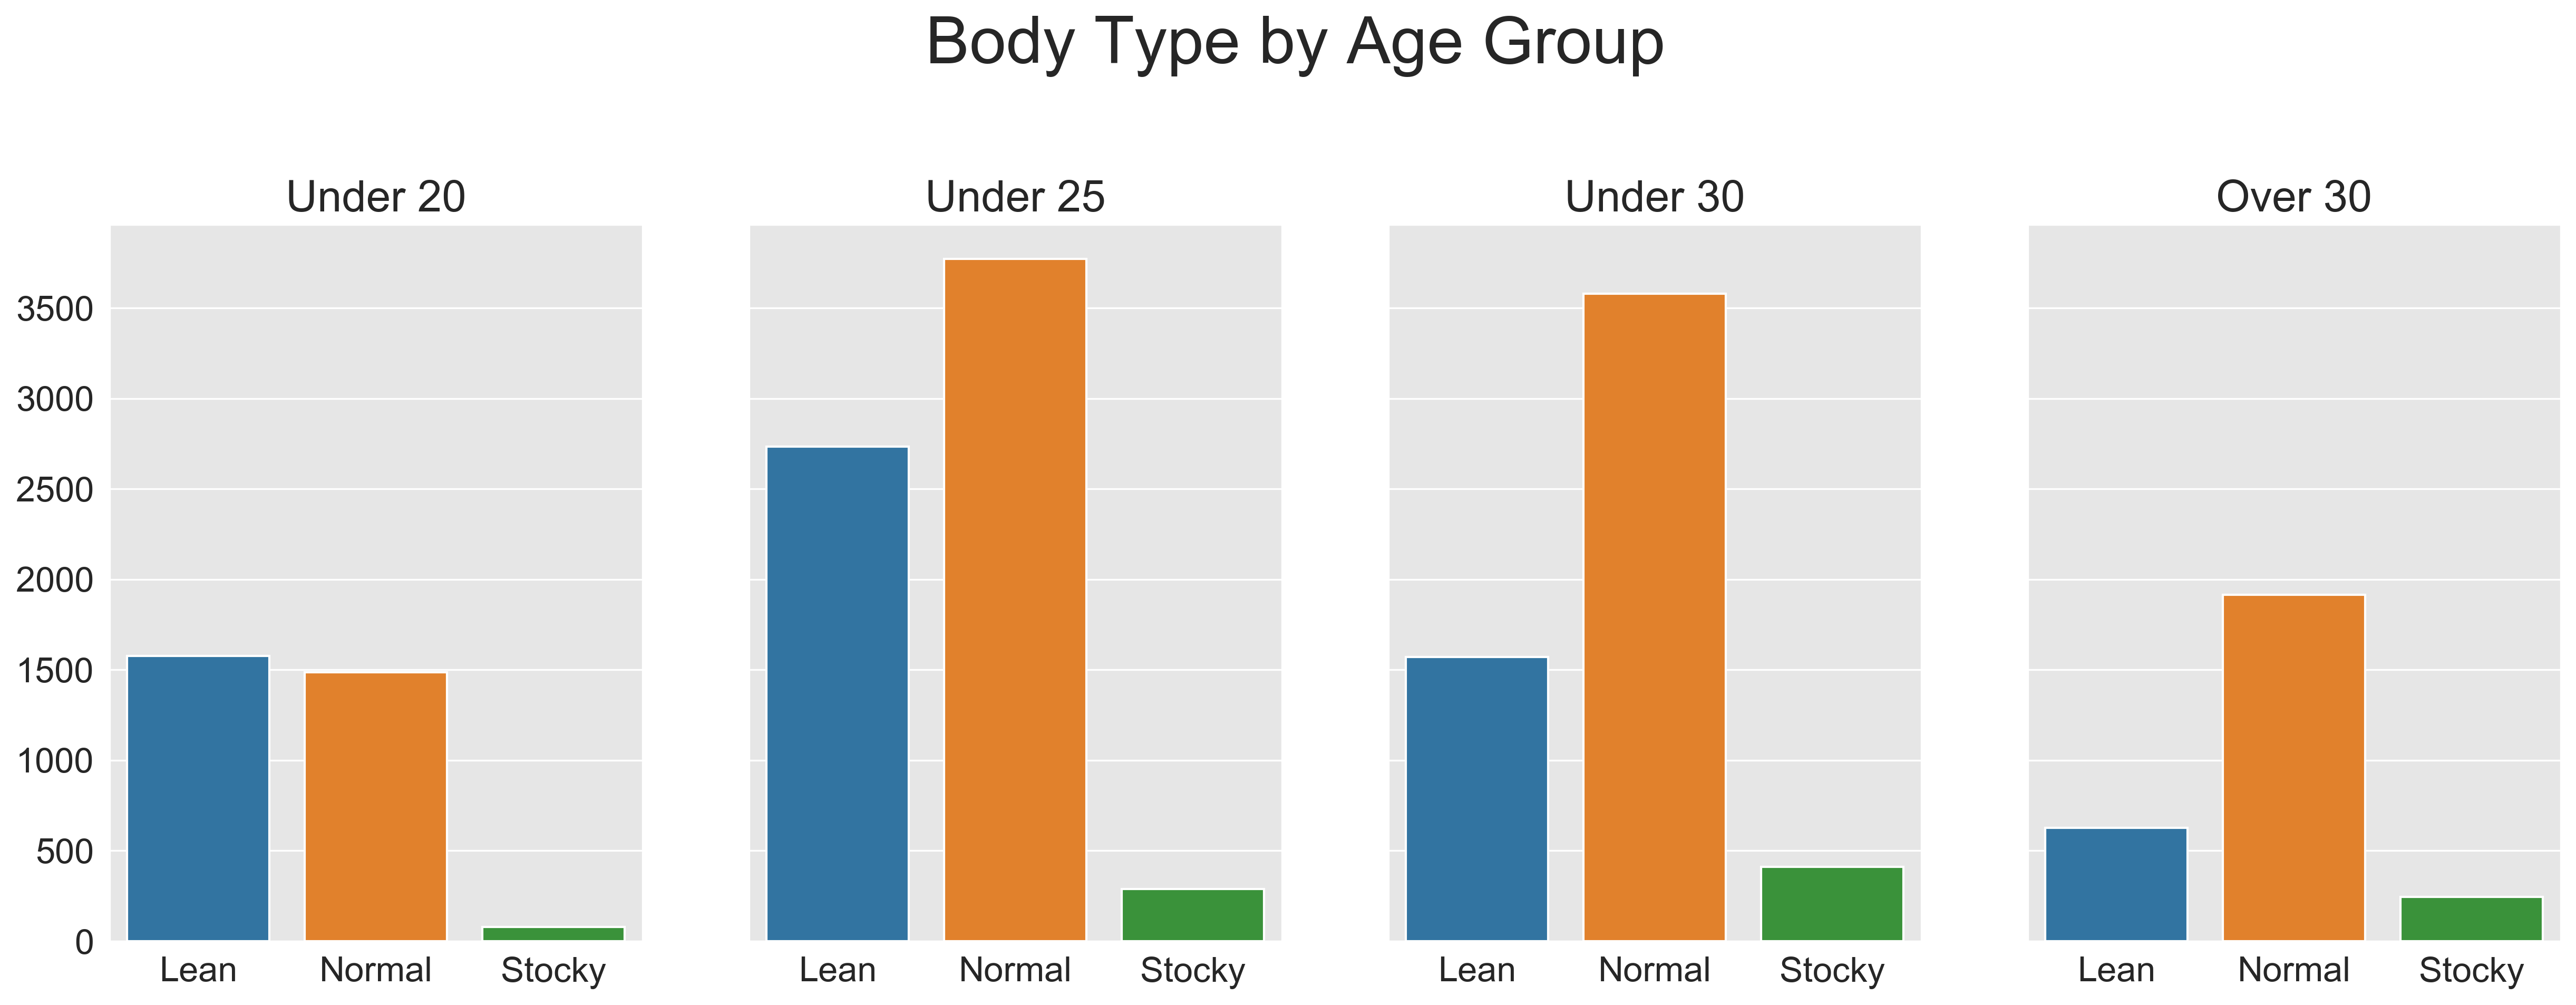

In [46]:
# subplot to  see body type and age group impacts on players
titlesize = 30
subtitlesize = 20
labelsize = 16


fig, axes = plt.subplots(1, 4, figsize=(20,6), dpi = 300, sharey=True)

fig.suptitle('Body Type by Age Group', fontsize = titlesize, y=1.1)     


sns.barplot(ax=axes[0], x="body_type", y="under 20", data=temp, dodge = False)
axes[0].set_title('Under 20', fontsize = subtitlesize)
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[0].tick_params(labelsize = labelsize)

sns.barplot(ax=axes[1], x="body_type", y="under 25", data=temp, dodge = False)
axes[1].set_title('Under 25', fontsize = subtitlesize)
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].tick_params(labelsize = labelsize)

sns.barplot(ax=axes[2], x="body_type", y="under 30", data=temp, dodge = False)
axes[2].set_title('Under 30', fontsize = subtitlesize)
axes[2].set_ylabel('')
axes[2].set_xlabel('')
axes[2].tick_params(labelsize = labelsize)

sns.barplot(ax=axes[3], x="body_type", y="over 30", data=temp, dodge = False)
axes[3].set_title('Over 30', fontsize = subtitlesize)
axes[3].set_ylabel('')
axes[3].set_xlabel('')
axes[3].tick_params(labelsize = labelsize)

### Positions

In [21]:
# Exploring top 10 player team positions.
team_positions = pd.DataFrame(fifa_20.groupby(by = 'team_position')['sofifa_id']\
                                .count().sort_values(ascending = False).nlargest(10))

# Exploring top 10 player main positions.
main_positions = pd.DataFrame(fifa_20.groupby(by = 'main_position')['sofifa_id']\
                                .count().sort_values(ascending = False).nlargest(10))

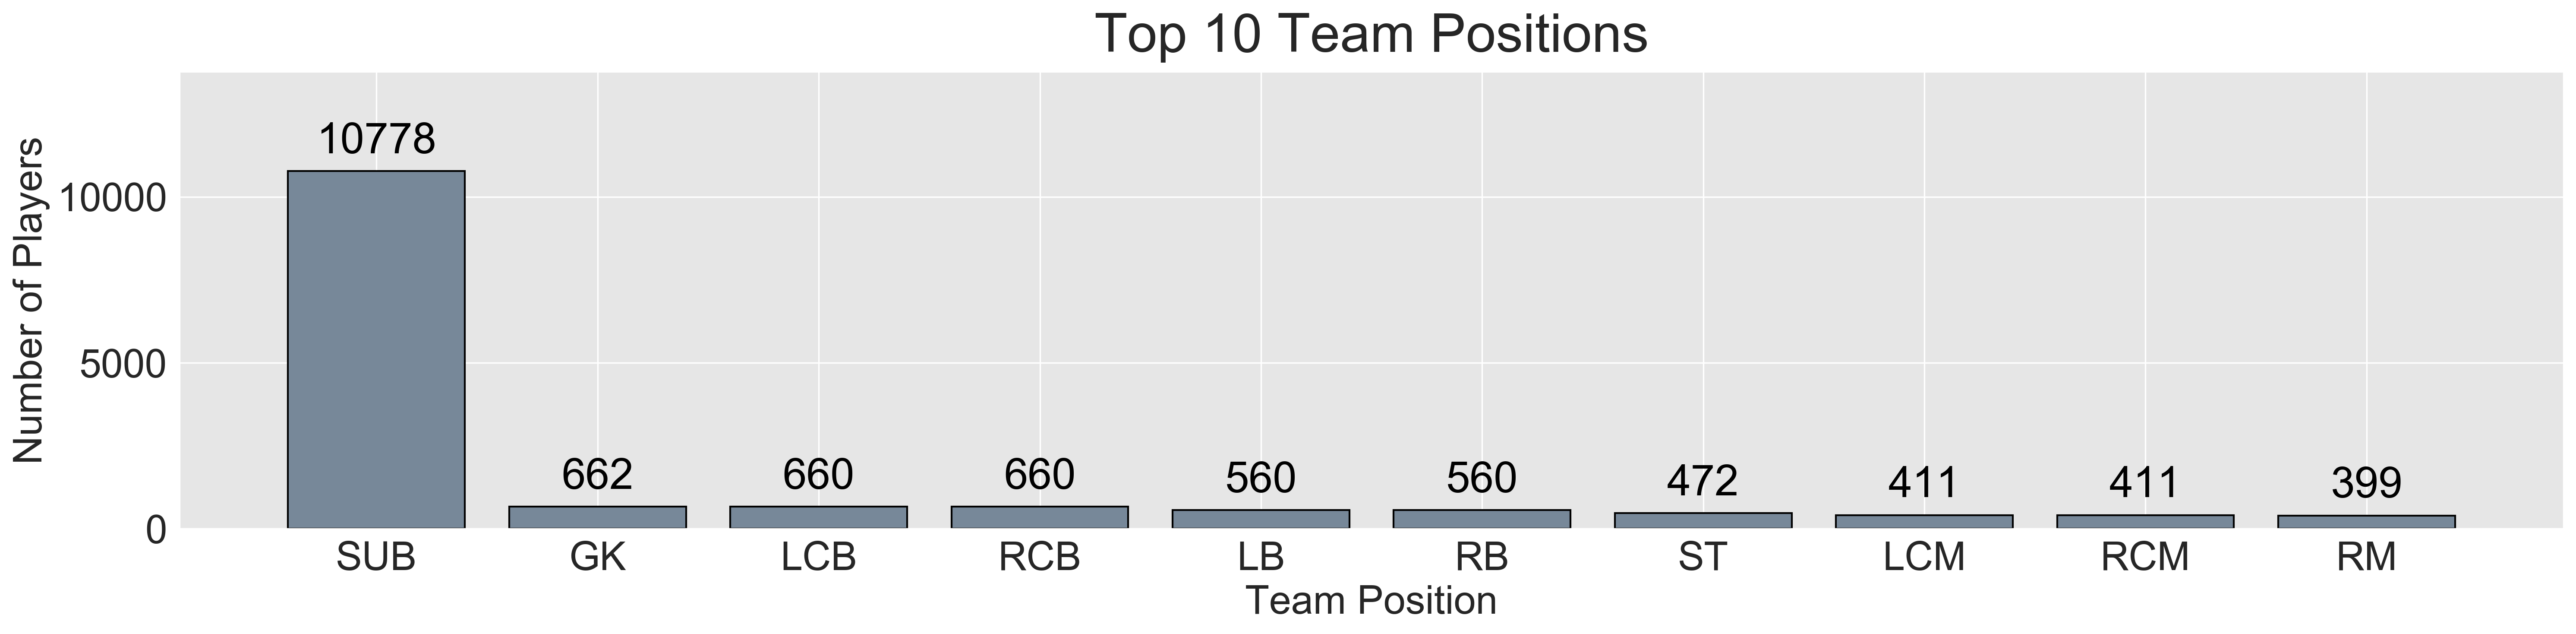

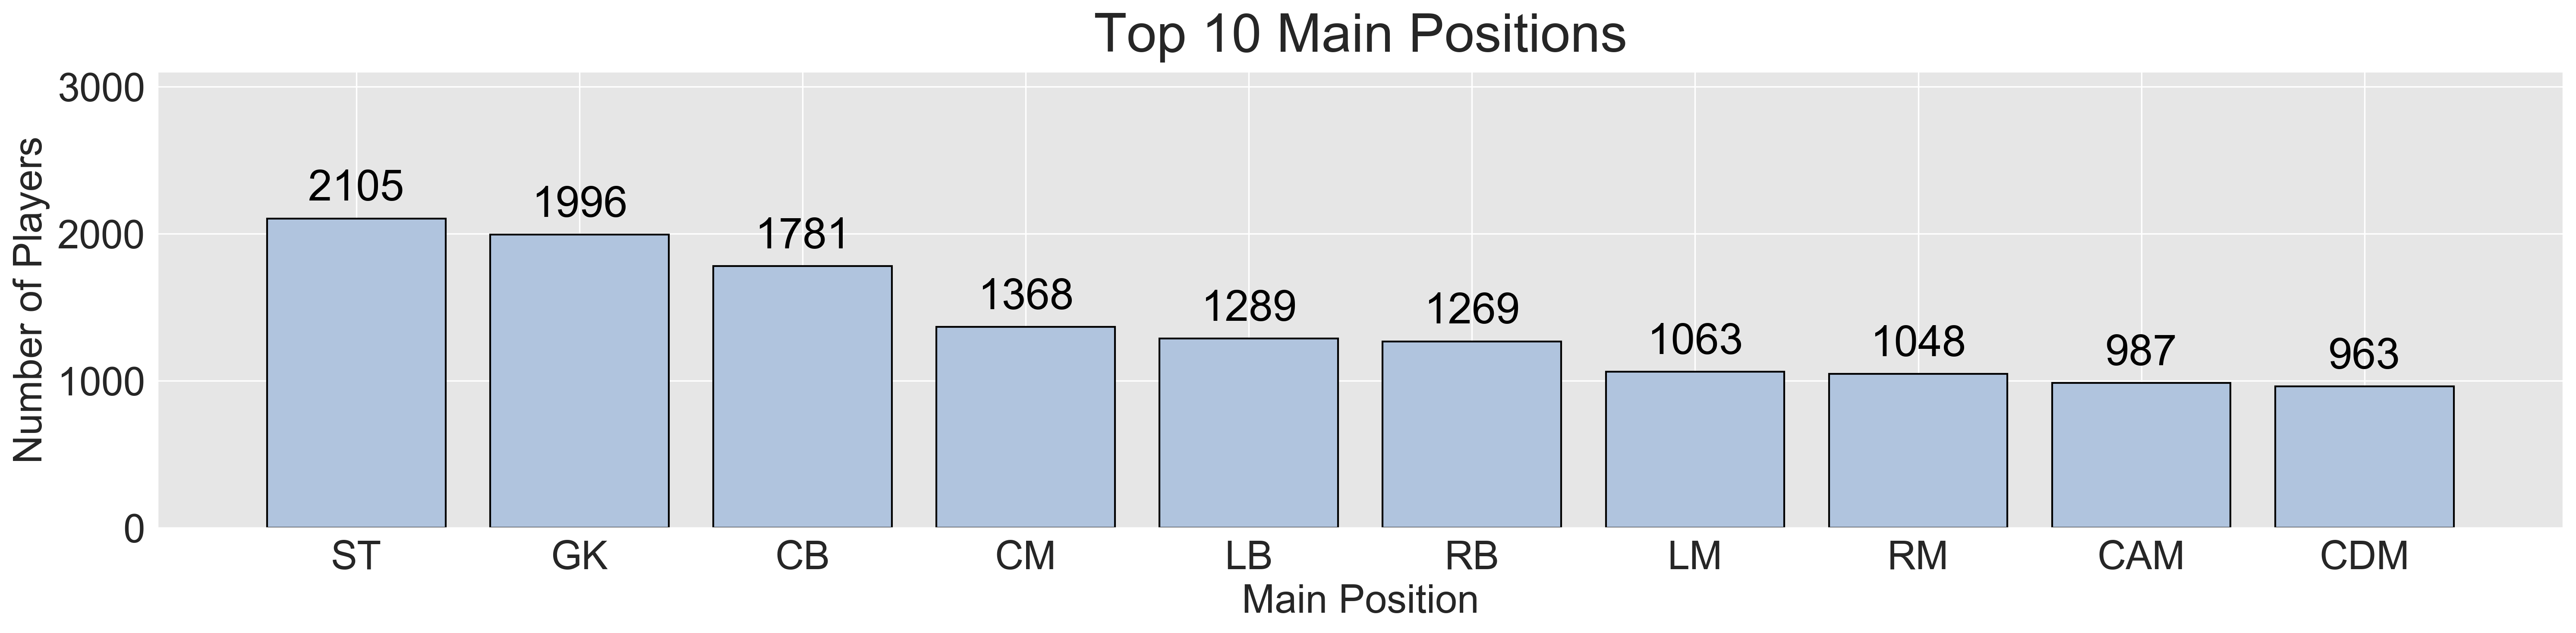

In [22]:
barplot_count(team_positions.index, team_positions['sofifa_id'], figsize = (20,5),
                  title = 'Top 10 Team Positions', ylabel = 'Number of Players', 
                  xlabel = 'Team Position', axis_fontsize = 22, 
                  title_fontsize = 30, barcolor = 'lightslategrey',
                  edgecolor = 'black', datalabelcolor = 'black',
                  datalabelheight = 0, datalabelsize = 24, ylim = 3000, 
                  )

barplot_count(main_positions.index, main_positions['sofifa_id'], figsize = (20,5),
                  title = 'Top 10 Main Positions', ylabel = 'Number of Players', 
                  xlabel = 'Main Position', axis_fontsize = 22, 
                  title_fontsize = 30, barcolor = 'lightsteelblue',
                  edgecolor = 'black', datalabelcolor = 'black',
                  datalabelheight = 0, datalabelsize = 24, ylim = 1000
                  )

### Clubs

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

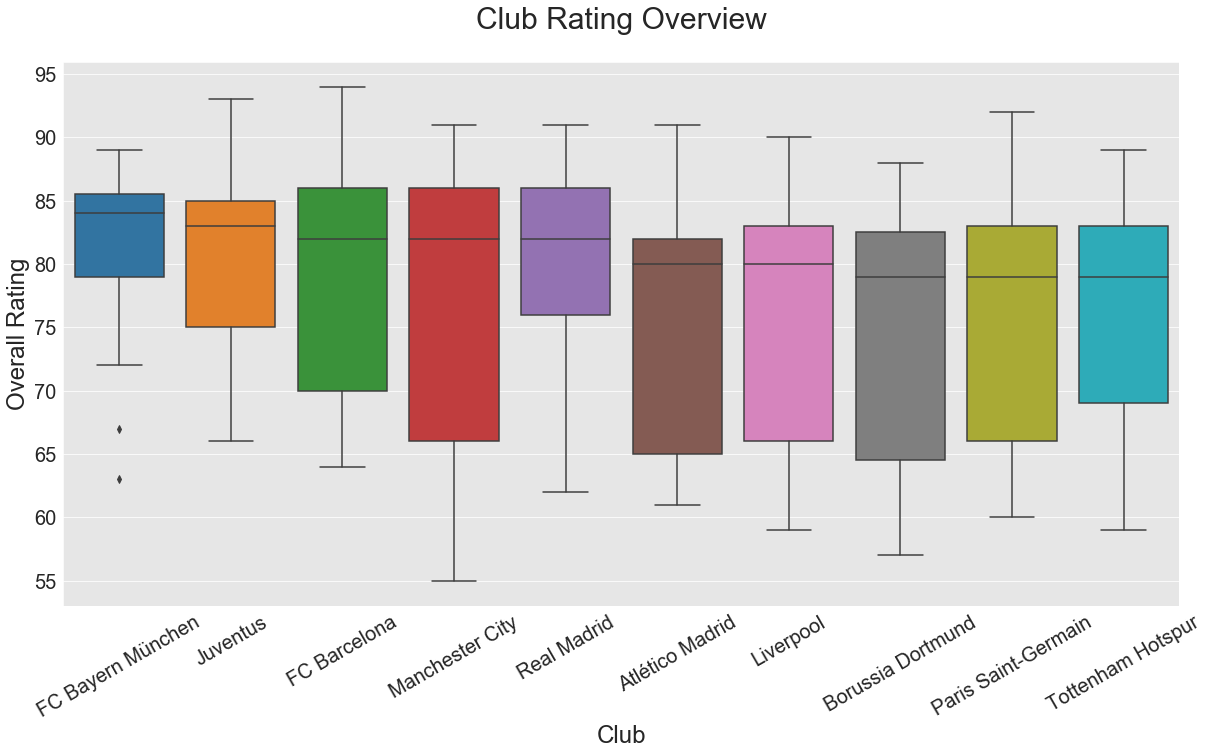

In [23]:
# creating list to filter based on team with the most players above 80 ratings
top_teams = list(fifa_20[fifa_20['overall'] >= 80]['club'].value_counts().nlargest(10).index)

# filtering for top teams list
top_teams_df = fifa_20[fifa_20['club'].isin(top_teams)]

# creating sorting for box plots based on median rating
grouped = top_teams_df.loc[:,['club', 'overall']] \
    .groupby(['club']) \
    .median() \
    .sort_values(by='overall', ascending = False)

# graphing boxplots
plt.figure(figsize = (20,10))
sns.boxplot(x="club", y="overall", data=top_teams_df, dodge = False, order=grouped.index)
plt.title('Club Rating Overview', fontsize = 30, y=1.05)
plt.ylabel('Overall Rating', fontsize = 24)
plt.xlabel('Club', fontsize = 24)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20, rotation = 30)

### Nationality

In [24]:
country_ratings = pd.DataFrame(fifa_20.groupby(by = 'nationality')['overall']\
                                    .agg({'min': 'min',
                                          'max': 'max', 
                                          'mean':'mean', 
                                          'median':'median',
                                          'count' : 'count'})\
                                    .round()\
                                    .astype('int64'))\
                                    .reset_index()\
                                    .sort_values('count', ascending = False)

/Users/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


In [25]:
# clubs with the most over 80 players
top_clubs = list(fifa_20[fifa_20['overall'] >= 80]['club'].value_counts().head(30).index)

# dataframe
top_clubs_df = fifa_20[(fifa_20['club'].isin(top_clubs)) & (fifa_20['nationality'] != 'Uruguay')][['sofifa_id', 'short_name', 'club','nationality', 'overall', 'main_position']]

top_countries = top_clubs_df['nationality'].value_counts().reset_index().head(10)

top_countries.columns = ['nationality', 'players']

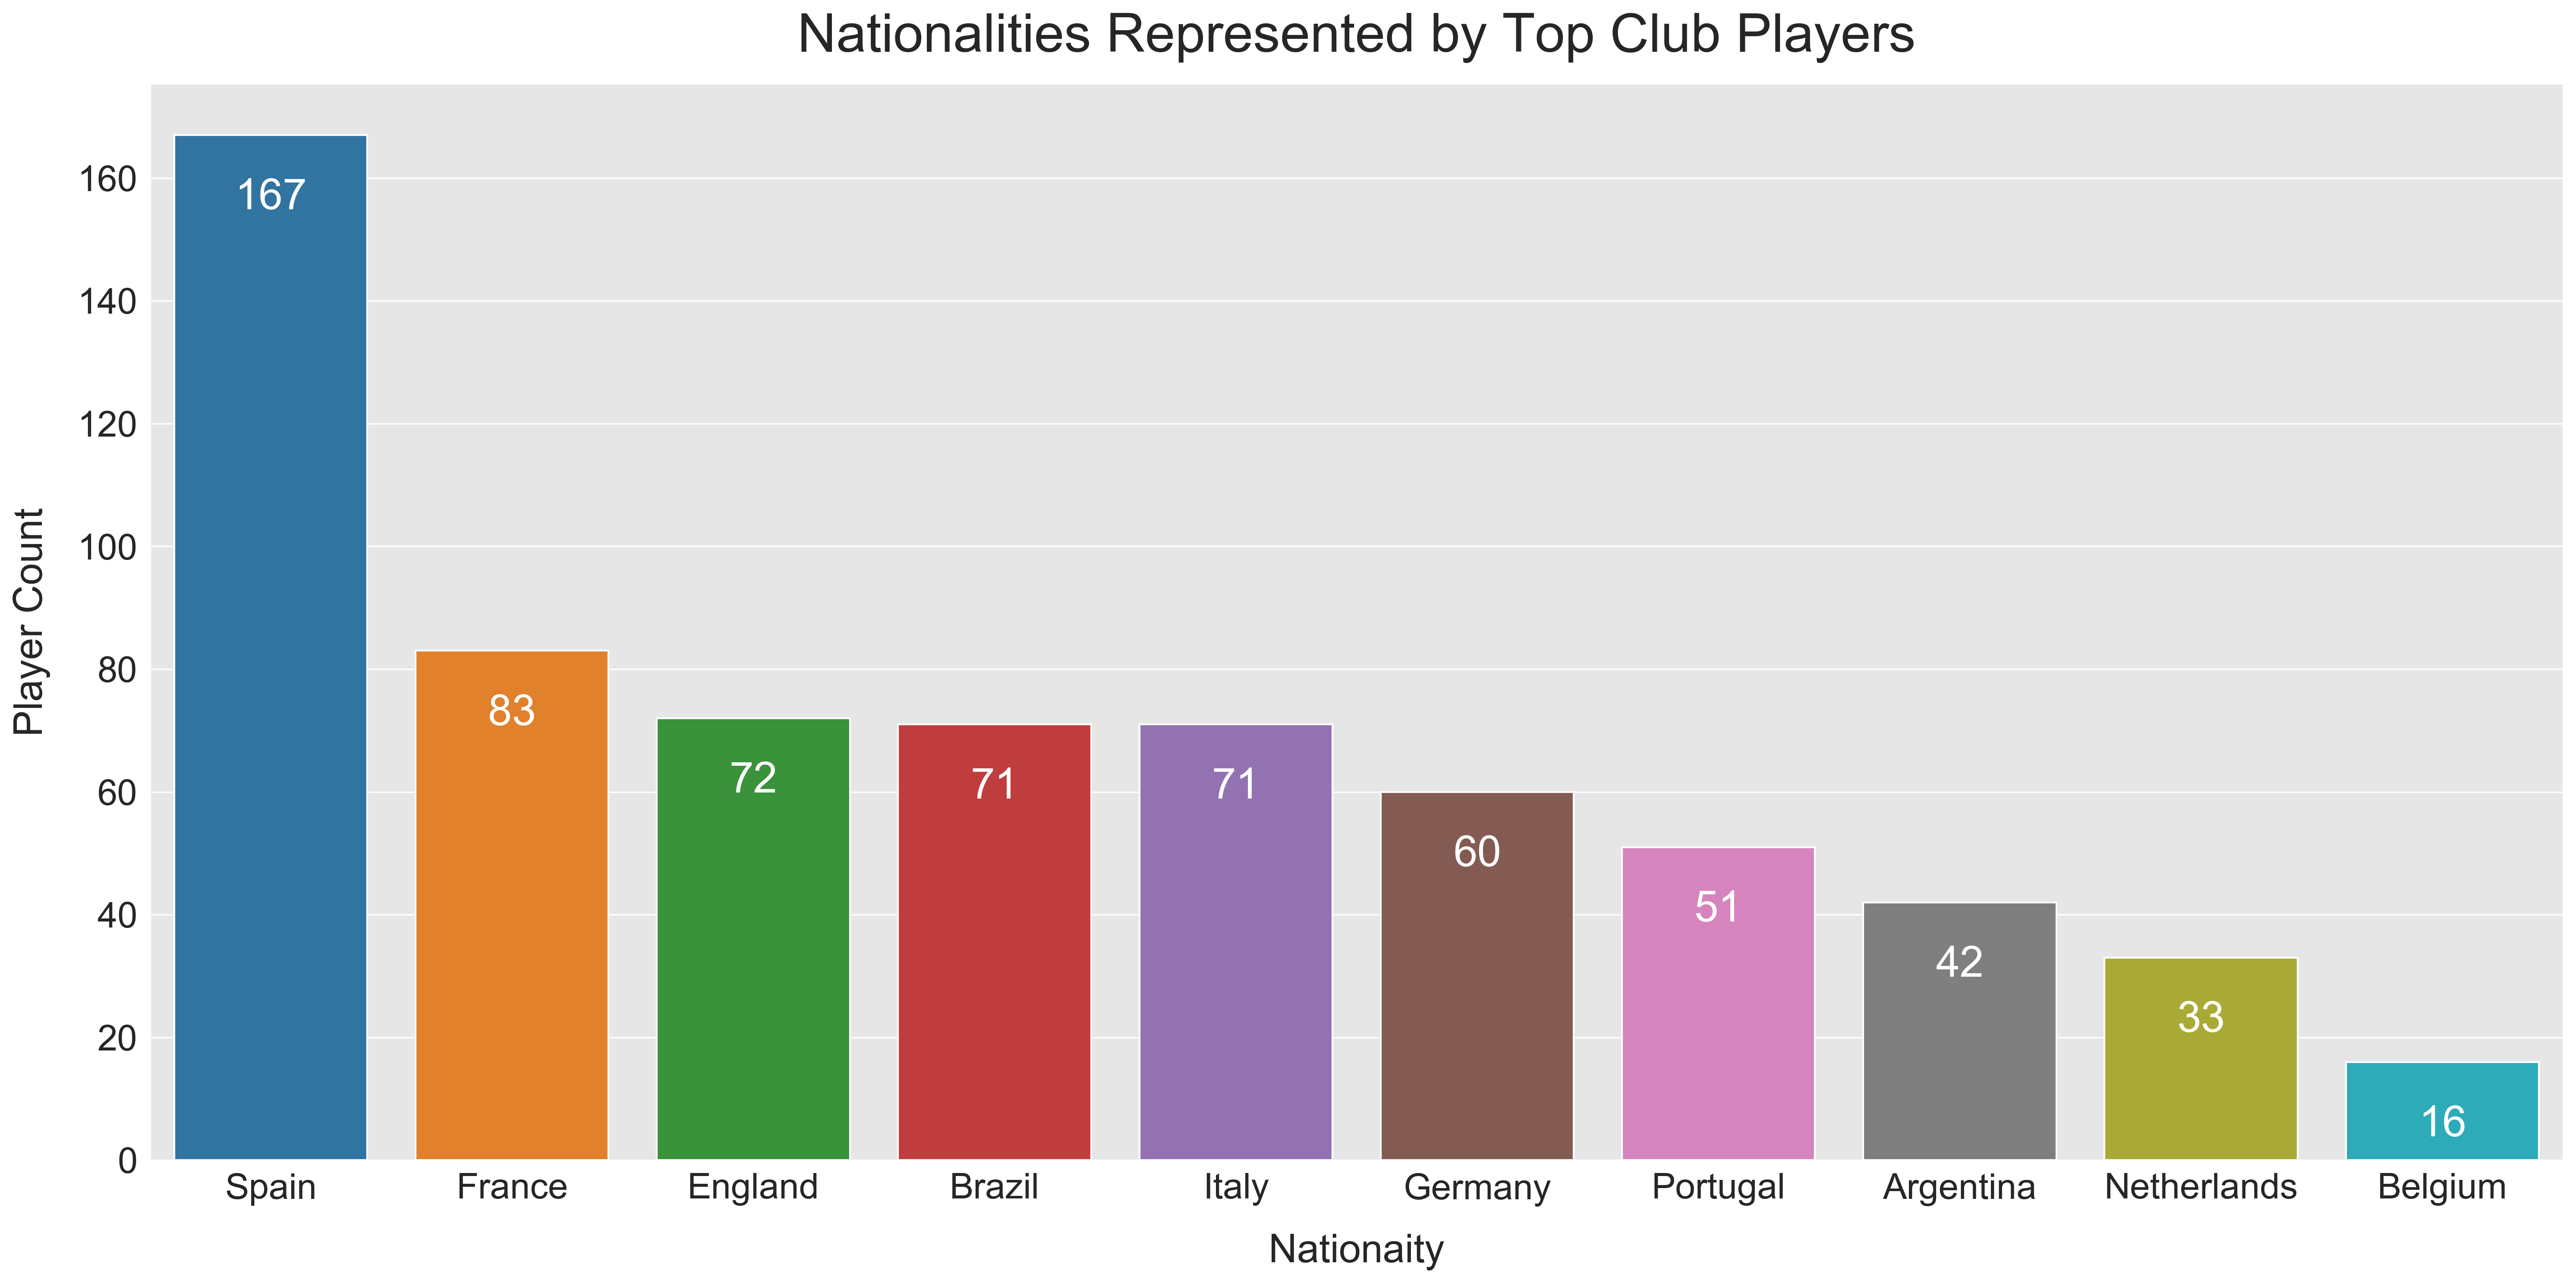

In [26]:
#setting figure standards
plt.figure(figsize = (20,10), dpi = 300)
pal = sns.color_palette("tab10")
        
sns.barplot(x = "nationality", y = "players", data = top_countries, palette = pal)

# data labels: zip joins x and y coordinates in pairs
for x,y in zip(top_countries['nationality'].index,top_countries['players']):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x,y-15), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext = (0,10), # distance from text to points (x,y)
                 ha = 'center',
                 fontsize = 24,
                 color = 'white') 

plt.title('Nationalities Represented by Top Club Players', fontsize = 30, y = 1.02)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Player Count", fontsize = 22, labelpad = 15)
plt.xlabel("Nationaity", fontsize = 22, labelpad = 15)
plt.tight_layout()
plt.show()

In [27]:
# aggregating on most club and nationality
countries = fifa_20.groupby(by = ['club', 'nationality'])['sofifa_id']\
                .count()\
                .reset_index()

# window style function to get row number ranking
countries['ranking'] = countries.sort_values(['sofifa_id'], ascending=False)\
                          .groupby(['club'])\
                          .cumcount() + 1

# checking average national players by club
countries[(countries['club'].isin(top_clubs)) & (countries['ranking'] == 1)].groupby('nationality')['sofifa_id'].mean().round()

nationality
England        11.0
France         12.0
Germany        11.0
Italy          10.0
Netherlands    14.0
Portugal       10.0
Spain          18.0
Uruguay        23.0
Name: sofifa_id, dtype: float64

### Potential

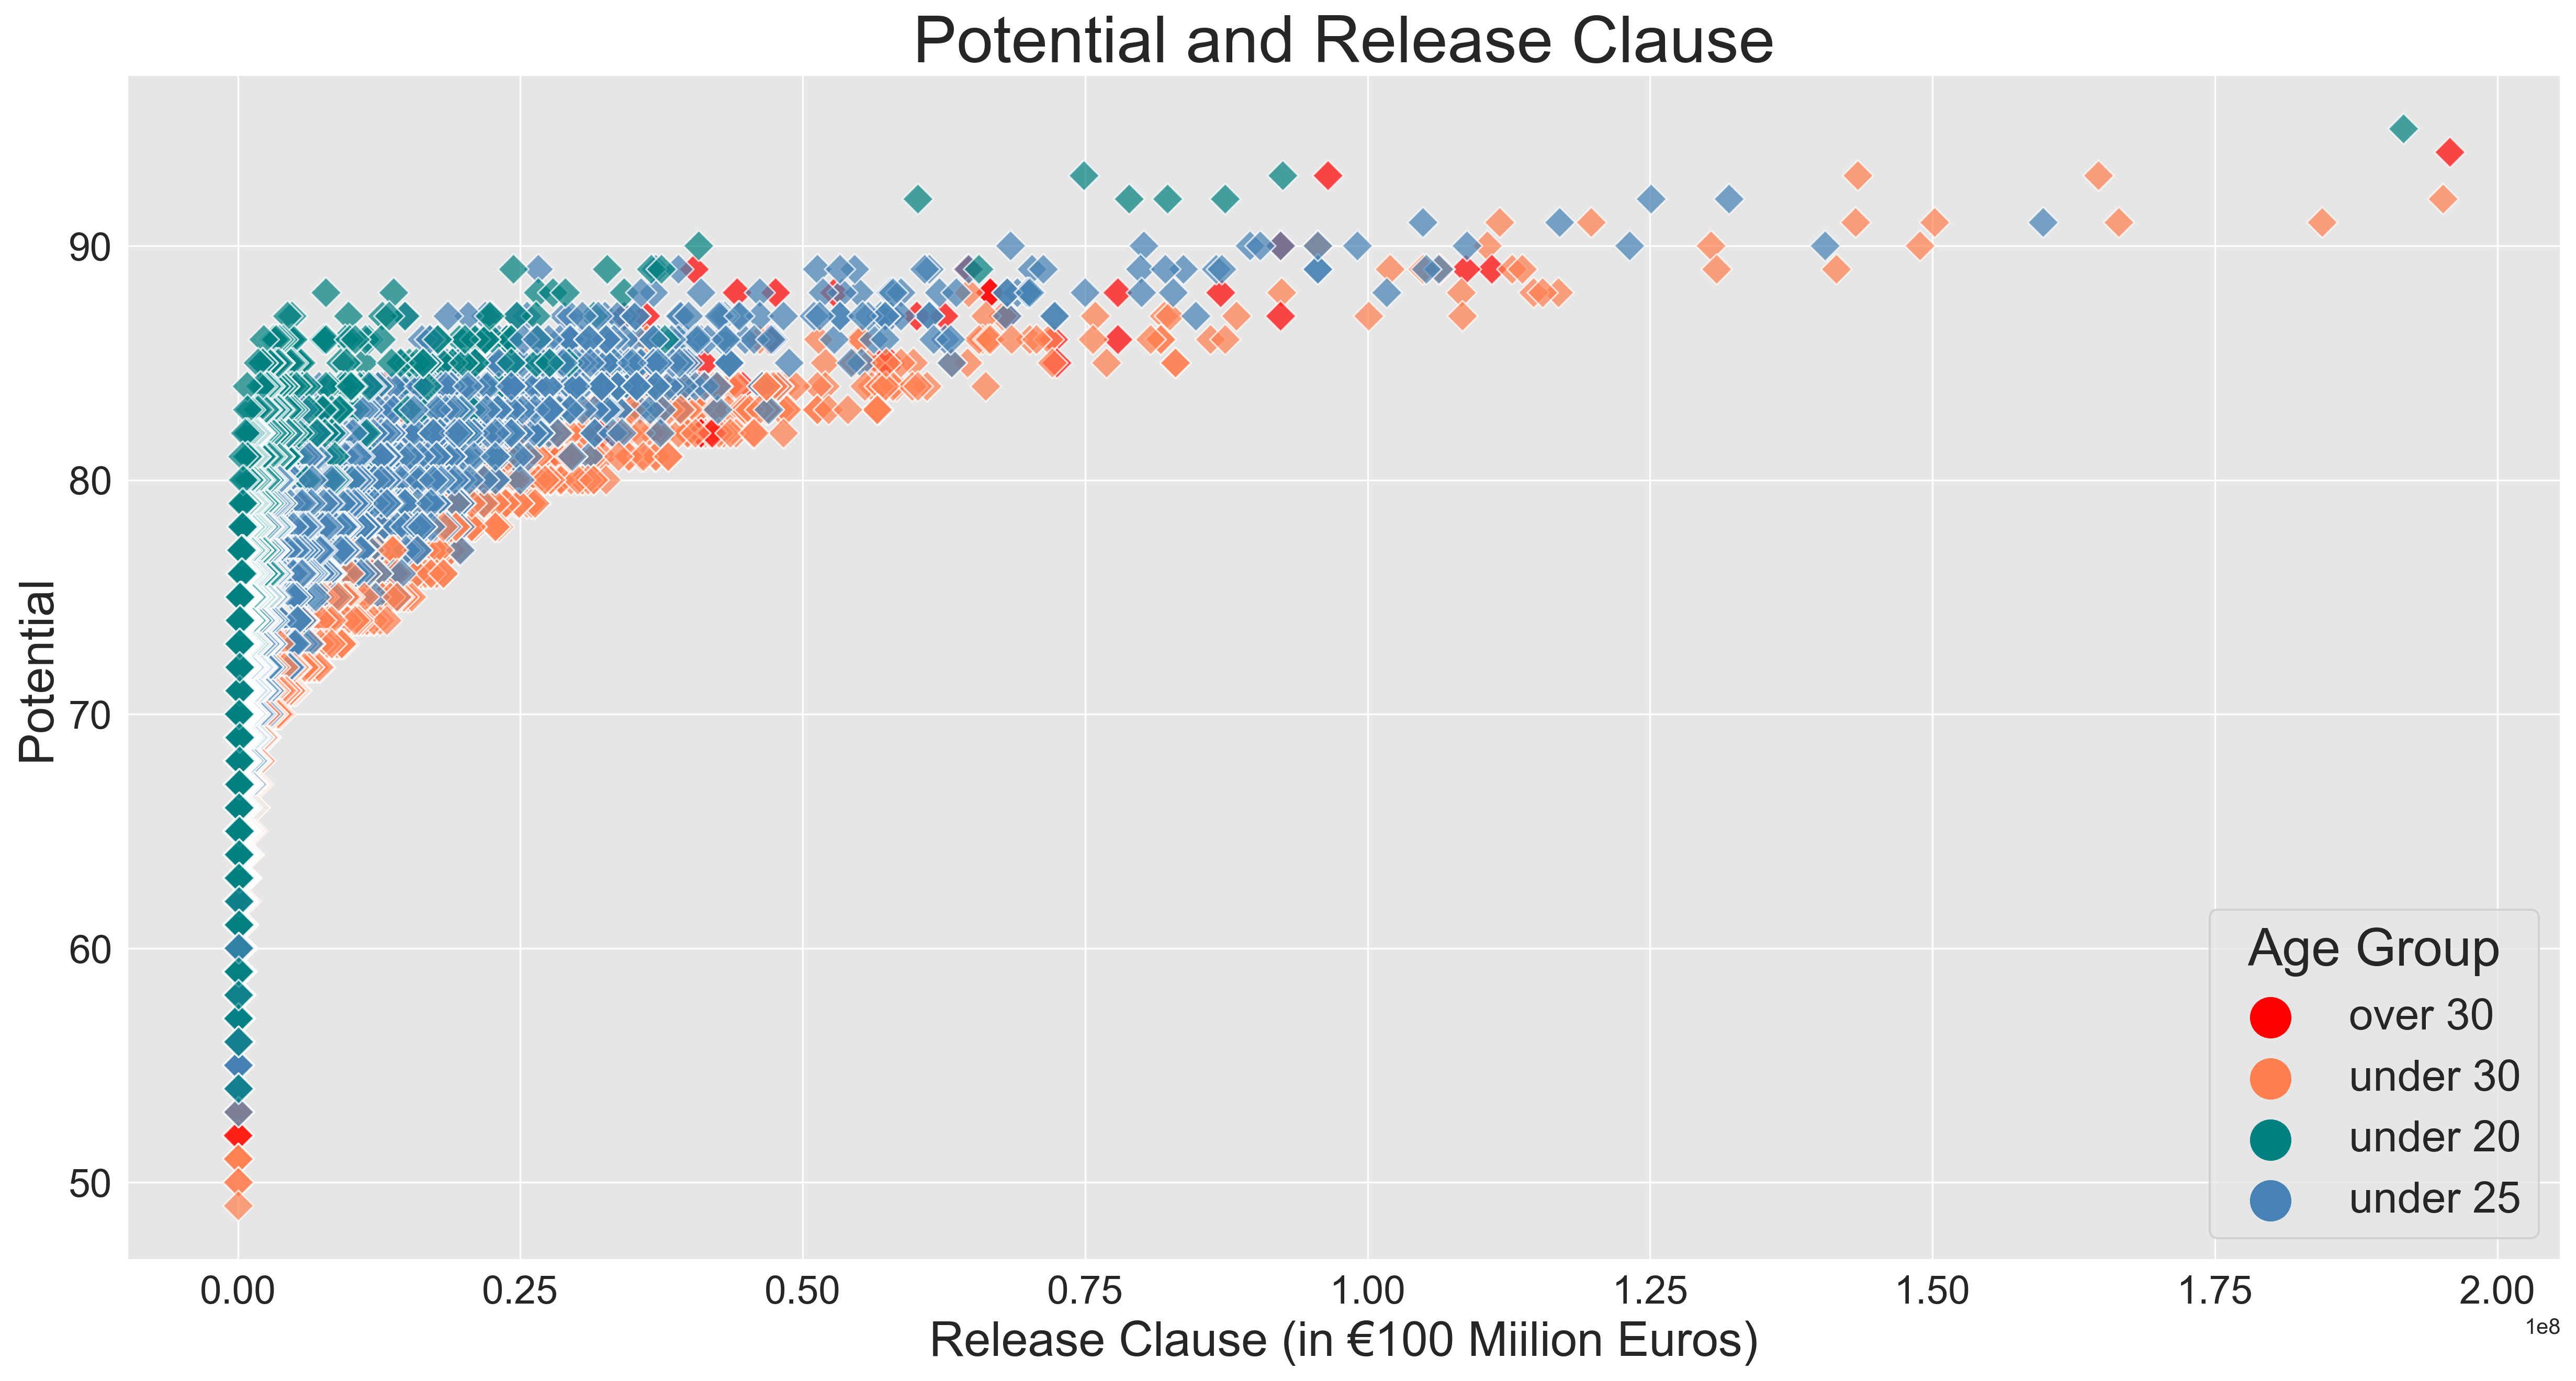

In [28]:
plt.figure(figsize =  (20,10), dpi = 300)
palette= ['red', 'coral', 'teal', 'steelblue']

sns.scatterplot(data=fifa_20, x="release_clause_eur", y="potential", 
                hue = 'age_group', marker = 'D', s = 100, 
                alpha = 0.7, palette = palette, x_jitter = True, y_jitter = True)
plt.title('Potential and Release Clause', fontsize = 30)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Potential", fontsize = 22)
plt.xlabel("Release Clause (in €100 Miilion Euros)", fontsize = 22)
plt.legend(loc = 'lower right', fontsize = 20,title="Age Group", 
           fancybox = True, title_fontsize = 24, markerscale = 3)

In [29]:
cols = ['age', 'overall', 'potential', 'value_eur', 'release_clause_eur']

# heat map for correlation
# heatMap(fifa_20.loc[:, cols], True)

fifa_20.loc[:, cols].corr().round(2)

,age,overall,potential,value_eur,release_clause_eur
age,1.00,0.46,-0.26,0.08,0.07
overall,0.46,1.00,0.65,0.64,0.63
potential,-0.26,0.65,1.00,0.58,0.60
value_eur,0.08,0.64,0.58,1.00,0.99
release_clause_eur,0.07,0.63,0.60,0.99,1.00


In [30]:
fifa_20[(fifa_20['age_group'] == 'under 20') 
        & (fifa_20['potential'] >= 90)
        & (fifa_20['release_clause_eur'] >= 50000000.0)][['short_name', 'potential', 'release_clause_eur']]

,short_name,potential,release_clause_eur
10,K. Mbappé,95,191700000.0
73,M. de Ligt,93,92500000.0
74,G. Donnarumma,92,78900000.0
108,J. Sancho,92,82300000.0
109,K. Havertz,92,87400000.0
411,João Félix,93,74900000.0
568,Vinícius Jr.,92,60200000.0


### Shirt Numbers

In [31]:
# creating rating groups
fifa_20['rating_group'] = ''

for index, row in fifa_20.iterrows():
    
    if row['overall'] <= 70:
        fifa_20.loc[index, 'rating_group'] = 'under 70'
    
    elif row['overall'] <= 80:
        fifa_20.loc[index, 'rating_group'] = 'under 80'
    
    elif row['overall'] <= 85:
        fifa_20.loc[index, 'rating_group'] = 'under 85'
    
    elif row['overall'] > 85:
        fifa_20.loc[index, 'rating_group'] = 'over 85'

In [32]:
# aggregating on most frequent jersey numbers
shirts = fifa_20.groupby(by = ['team_jersey_number', 'team_position'])['sofifa_id']\
                .count()\
                .reset_index()

# excluding SUBSTITUTUES
shirts = shirts[shirts['team_position'] != 'SUB']

In [33]:
# window style function to get row number ranking
shirts['ranking'] = shirts.sort_values(['sofifa_id'], ascending=False)\
                          .groupby(['team_jersey_number'])\
                          .cumcount() + 1

In [34]:
#selecting only top jersey count per position
main_shirt_numbers = shirts[shirts['ranking'] == 1]

# converting to integer
main_shirt_numbers['team_jersey_number'] = main_shirt_numbers.loc[:,'team_jersey_number'].astype('int64')

# new column for graphing
main_shirt_numbers['jersey_position'] = '#' + main_shirt_numbers['team_jersey_number'].astype('str') + ' (' + main_shirt_numbers['team_position'] + ')'

/Users/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jason/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


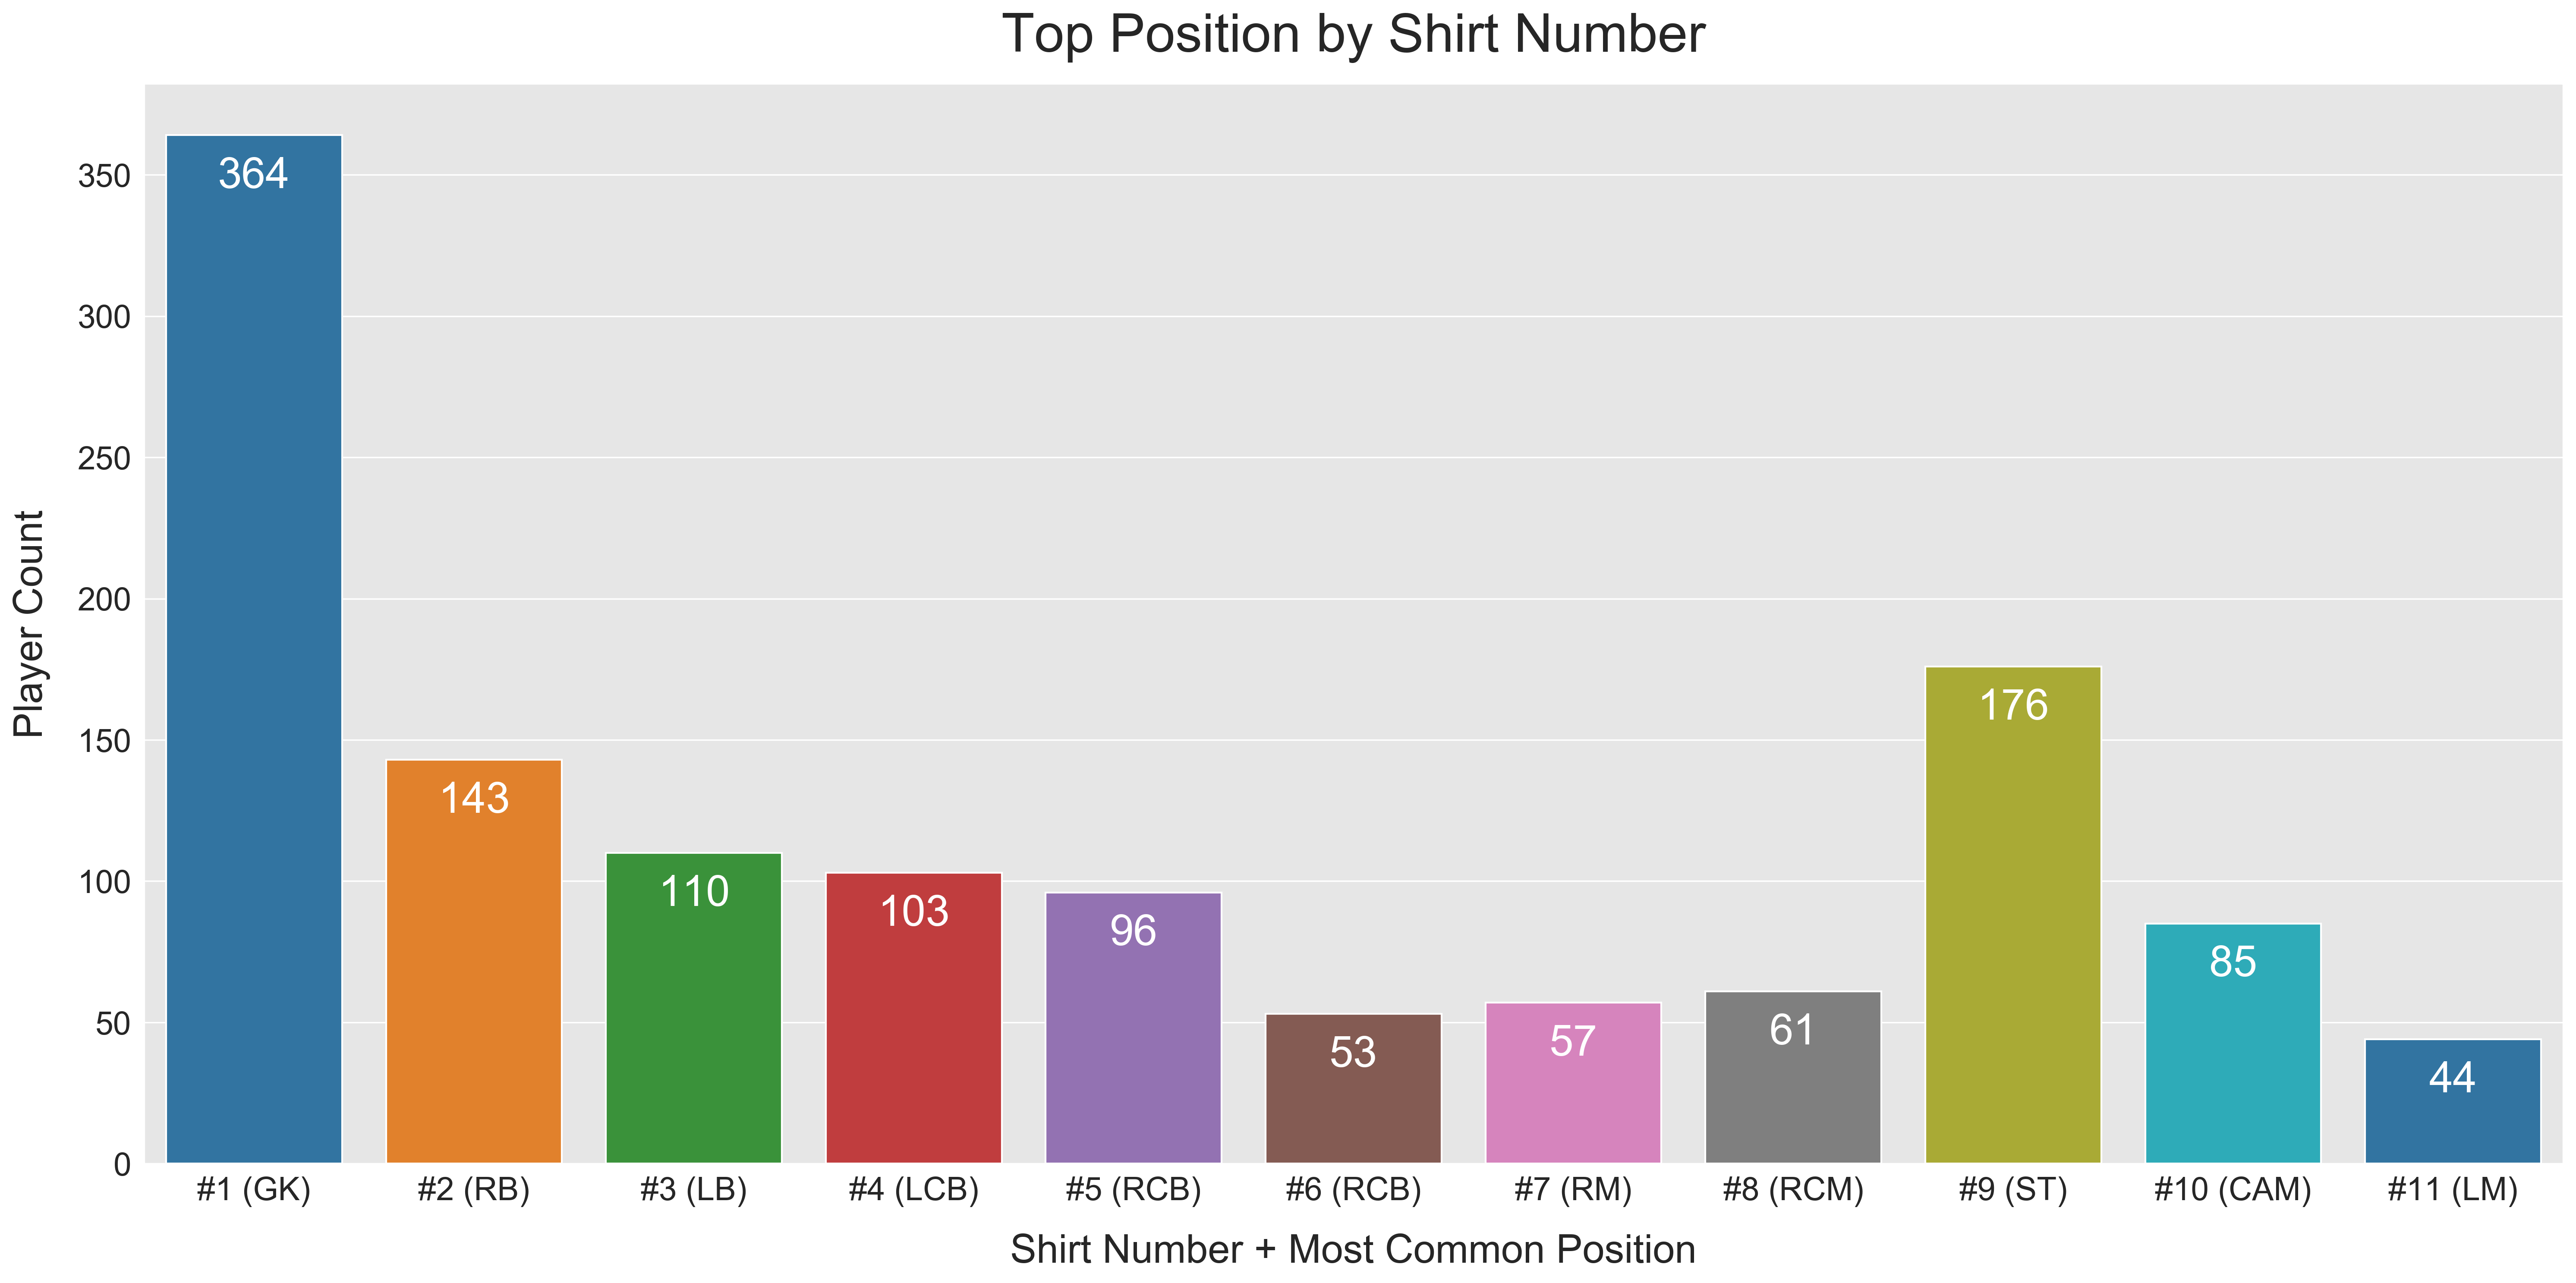

In [35]:
# graphing players shirt numbers and main positions
df = main_shirt_numbers.iloc[:11,:]

#setting figure standards
plt.figure(figsize = (20,10), dpi = 300)
pal = sns.color_palette("tab10")
        
sns.barplot(x = "team_jersey_number", y = "sofifa_id", data = df, palette = pal)

# data labels: zip joins x and y coordinates in pairs
for x,y in zip(df['team_jersey_number'],df['sofifa_id']):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x-1,y-25), # this is the point to label
                 textcoords = "offset points", # how to position the text
                 xytext = (0,10), # distance from text to points (x,y)
                 ha = 'center',
                 fontsize = 24,
                 color = 'white') 

plt.title('Top Position by Shirt Number', fontsize = 30, y = 1.02)
plt.xticks(fontsize = 18, ticks = np.arange(11), labels = list(df['jersey_position']))
plt.yticks(fontsize = 18)
plt.ylabel("Player Count", fontsize = 22, labelpad = 15)
plt.xlabel("Shirt Number + Most Common Position", fontsize = 22, labelpad = 15)
plt.tight_layout()
plt.show()

In [36]:
fifa_20[fifa_20['team_jersey_number'] == 9][['short_name', 'overall', 'club', 'team_position']].head()

,short_name,overall,club,team_position
19,L. Suárez,89,FC Barcelona,ST
20,R. Lewandowski,89,FC Bayern München,ST
34,E. Cavani,88,Paris Saint-Germain,ST
46,K. Benzema,87,Real Madrid,ST
63,Roberto Firmino,86,Liverpool,ST
